In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import zscore


# plotting modules
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib.colors as colors
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 5, 'ytick.major.width': 1.5, 'ytick.major.size': 4})
from matplotlib.backends.backend_pdf import PdfPages


In [2]:
def save_pdf(save_file, fig):
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight')
    pdf.close()
    return

In [3]:
libs = ["CC", "ATF2", "CTCF", "FOXA1", "LEF1", "SCRT1", "TCF7L2", "16P12_1"]
root_dir = "../data/"
classification_types = ["peaks_vs_notpeaks", "responsive_vs_nonresponsive", "induced_vs_repressed"]

In [4]:
def get_sorted_features(root_dir, lib_name, classification_type):
    feature_file = os.path.join(root_dir, lib_name, classification_type, "linear", f"features.csv")
    df_feature = pd.read_csv(feature_file, header=0, names=["TF_with_strand", "weight"])
    df_feature["weight"] = zscore(df_feature.weight.values)
    df_feature = pd.concat((df_feature, df_feature.TF_with_strand.str.split("|", expand=True)), axis=1)
    df_feature = df_feature.rename(columns={0: "TF", 1: "strand"}).drop(columns=["TF_with_strand"])
    df_feature = df_feature.groupby(by=["TF"]).max().drop(columns=["strand"])
    df_feature = df_feature.iloc[df_feature.weight.abs().argsort()].iloc[::-1]
    return df_feature.reset_index()

def get_lib_specific_features(df, npos, nneg):
    pos_features = df.loc[df.weight>0].head(npos).TF.values
    neg_features = df.loc[df.weight<0].head(nneg).TF.values
    all_features = np.append(pos_features, neg_features)
    return list(all_features)

def get_top_feature_union(dfs_info, npos=10, nneg=5):
    top_features = set(sum([get_lib_specific_features(df[2], npos, nneg) for df in dfs_info], []))
    dfs_info_filtered = []
    for tf, ct, df in dfs_info:
        df_tf_ct = df.loc[df.TF.isin(top_features)]
        df_tf_ct["TF"] = df_tf_ct.TF.str.split(".").str[0].str.split("_").str[0]
        df_tf_ct["lib_name"] = tf
        df_tf_ct["classification"] = ct
        dfs_info_filtered.append(df_tf_ct)
    return pd.concat(dfs_info_filtered).reset_index(drop=True)

# Peaks features

In [5]:
lib_peak_features_dfs = [(lib, classification_types[0], get_sorted_features(root_dir, lib, classification_types[0])) for lib in libs[0:-1]]
lib_peak_top_features_df = get_top_feature_union(lib_peak_features_dfs, npos=10, nneg=5)
peak_df = lib_peak_top_features_df.drop(columns=["classification"]).pivot(index=["lib_name"], columns=["TF"])
peak_df.index.name = None
peak_df.columns = peak_df.columns.get_level_values(1)
peak_df = peak_df.loc[libs[:-1],:]

/tmp/ipykernel_618347/2836314447.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tf_ct["TF"] = df_tf_ct.TF.str.split(".").str[0].str.split("_").str[0]
/tmp/ipykernel_618347/2836314447.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tf_ct["lib_name"] = tf
/tmp/ipykernel_618347/2836314447.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [6]:
peak_df.values.flatten().min(), peak_df.values.flatten().max()

(-2.280497364459917, 6.979350911458195)

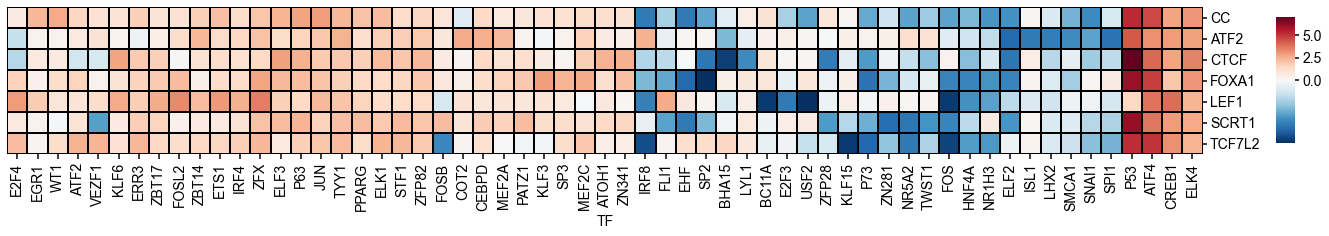

In [7]:
divnorm=colors.TwoSlopeNorm(vmin=-2, vcenter=0., vmax=7)

cg = sns.clustermap(
    peak_df,
    figsize=(18, 3.5),
    linewidths=0.004,
    cmap="RdBu_r",
    norm=divnorm,
    dendrogram_ratio=(0.01, 0),
    cbar_pos=(1,0.4, 0.015, 0.5),
    linecolor="k",
    col_cluster=True,
    row_cluster=False,
    )

cg.ax_row_dendrogram.set_visible(False)

In [8]:
save_file = "../data/figures/linear/peaks_heatmap.pdf"
save_pdf(save_file, cg.fig)

# Response features

In [9]:
lib_response_features_dfs = [(lib, classification_types[0], get_sorted_features(root_dir, lib, classification_types[1])) for lib in libs[1:-1]]
lib_response_top_features_df = get_top_feature_union(lib_response_features_dfs, npos=5, nneg=5)
response_df = lib_response_top_features_df.drop(columns=["classification"]).pivot(index=["lib_name"], columns=["TF"])
response_df.index.name = None
response_df.columns = response_df.columns.get_level_values(1)
response_df.values.flatten().min(), response_df.values.flatten().max()

/tmp/ipykernel_618347/2836314447.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tf_ct["TF"] = df_tf_ct.TF.str.split(".").str[0].str.split("_").str[0]
/tmp/ipykernel_618347/2836314447.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tf_ct["lib_name"] = tf
/tmp/ipykernel_618347/2836314447.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

(-2.642759713274003, 7.754738355829436)

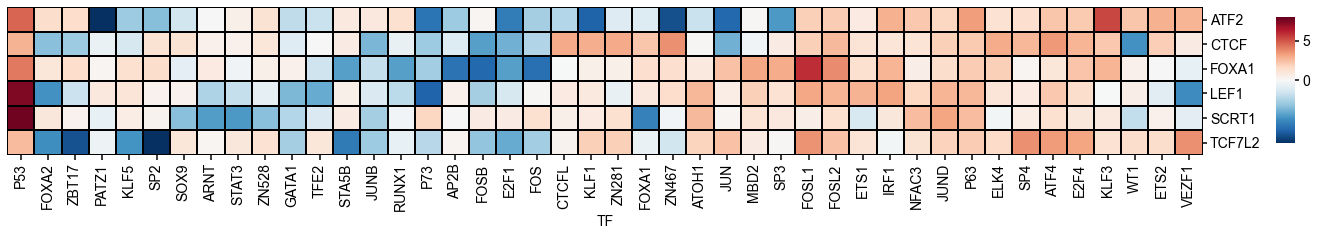

In [10]:
divnorm=colors.TwoSlopeNorm(vmin=-2.5, vcenter=0., vmax=8)

cg = sns.clustermap(
    response_df,
    figsize=(18, 3.5),
    linewidths=0.004,
    cmap="RdBu_r",
    norm=divnorm,
    dendrogram_ratio=(0.01, 0),
    cbar_pos=(1,0.4, 0.015, 0.5),
    linecolor="k",
    col_cluster=True,
    row_cluster=False,
    )

cg.ax_row_dendrogram.set_visible(False)

In [11]:
save_file = "../data/figures/linear/response_heatmap.pdf"
save_pdf(save_file, cg.fig)

# Response type

In [12]:
lib_rtype_features_dfs = [(lib, classification_types[0], get_sorted_features(root_dir, lib, classification_types[2])) for lib in libs[1:-1]]
lib_rtype_top_features_df = get_top_feature_union(lib_rtype_features_dfs, npos=5, nneg=5)
rtype_df = lib_rtype_top_features_df.drop(columns=["classification"]).pivot(index=["lib_name"], columns=["TF"])
rtype_df.index.name = None
rtype_df.columns = rtype_df.columns.get_level_values(1)
rtype_df.values.flatten().min(), rtype_df.values.flatten().max()

/tmp/ipykernel_618347/2836314447.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tf_ct["TF"] = df_tf_ct.TF.str.split(".").str[0].str.split("_").str[0]
/tmp/ipykernel_618347/2836314447.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tf_ct["lib_name"] = tf
/tmp/ipykernel_618347/2836314447.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

(-4.63878108087192, 3.3429285542624663)

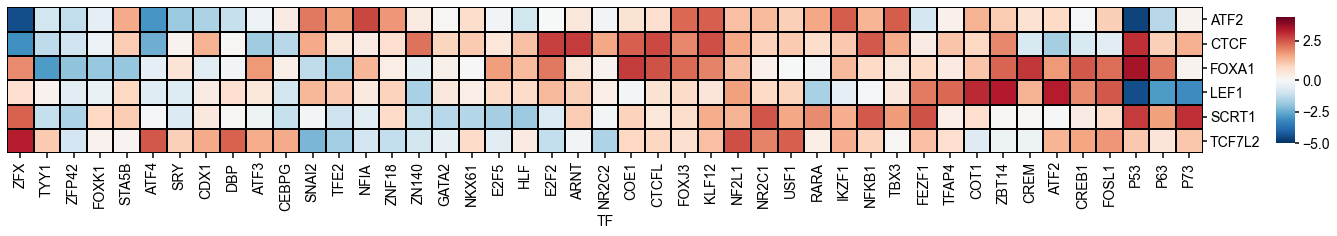

In [13]:
divnorm=colors.TwoSlopeNorm(vmin=-5, vcenter=0., vmax=4)

cg = sns.clustermap(
    rtype_df,
    figsize=(18, 3.5),
    linewidths=0.004,
    cmap="RdBu_r",
    norm=divnorm,
    dendrogram_ratio=(0.01, 0),
    cbar_pos=(1,0.4, 0.015, 0.5),
    linecolor="k",
    col_cluster=True,
    row_cluster=False,
    )

cg.ax_row_dendrogram.set_visible(False)

In [14]:
save_file = "../data/figures/linear/rtype_heatmap.pdf"
save_pdf(save_file, cg.fig)